In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


In [3]:
%gui qt

## Load behavior

In [3]:
from scipy.io import loadmat

In [4]:
behav = loadmat('./rec02-whl_fix.mat')

In [5]:
behav

{'A': array([[17.42025]]),
 'AfileOffset': array([[348405]], dtype=int32),
 'B': array([[20.82025]]),
 'BfileOffset_self': array([[416405]], dtype=int32),
 'C': array([[3.4]]),
 'LEDchannels': array([[6]], dtype=uint8),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec 13 22:56:27 2018',
 '__version__': '1.0',
 'ans': array([[416405]], dtype=int32),
 'theoffset': array([[4250.]]),
 'whlDataLfp': array([[3.36925374e+03, 1.53000000e+02, 3.13000000e+02, ...,
         3.13000000e+02, 1.63000000e+02, 3.04000000e+02],
        [3.37005328e+03, 1.53000000e+02, 3.13000000e+02, ...,
         3.13000000e+02, 1.63000000e+02, 3.04000000e+02],
        [3.37085282e+03, 1.53000000e+02, 3.13000000e+02, ...,
         3.13000000e+02, 1.63000000e+02, 3.04000000e+02],
        ...,
        [2.59548265e+06, 4.80000000e+02, 3.34000000e+02, ...,
         3.34000000e+02, 4.94000000e+02, 3.31000000e+02],
        [2.59548345e+06, 4.80000000e+02, 3.34000000e+02, ...,
 

In [6]:
pos_data = loadmat('./rec02-whl_fix.mat')['whlDataLfp']

In [7]:
pos = pos_data[:,-2:]

In [8]:
from spiketag.analysis import place_field

/anaconda2/lib/python2.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [9]:
pc = place_field()

In [10]:
fs = 1250.
ts = np.arange(0, pos.shape[0]/fs, 1/fs)

In [11]:
new_fs = 60.
pc.ts, pc.pos = pc.interp_pos(ts, pos, N=fs/new_fs)

In [12]:
ephys_start_time = 1.461
ephys_end_time = 2462
pc.ts = pc.ts + ephys_start_time
pc.ts, pc.pos = pc.ts[pc.ts<ephys_end_time], pc.pos[pc.ts<ephys_end_time]

In [13]:
pc.ts

array([1.46100000e+00, 1.47766667e+00, 1.49433333e+00, ...,
       2.46196100e+03, 2.46197767e+03, 2.46199433e+03])

In [14]:
pc.pos

array([[163.        , 304.        ],
       [163.        , 304.        ],
       [163.        , 304.        ],
       ...,
       [140.        , 143.        ],
       [140.        , 144.        ],
       [140.66666667, 144.66666667]])

In [15]:
bin_size = 5
v_cutoff = 15
pc.initialize(bin_size=bin_size, v_cutoff=v_cutoff)  #, maze_range=np.array([[100,500], [100,500]])

In [16]:
pc.dt

0.016666666666666607

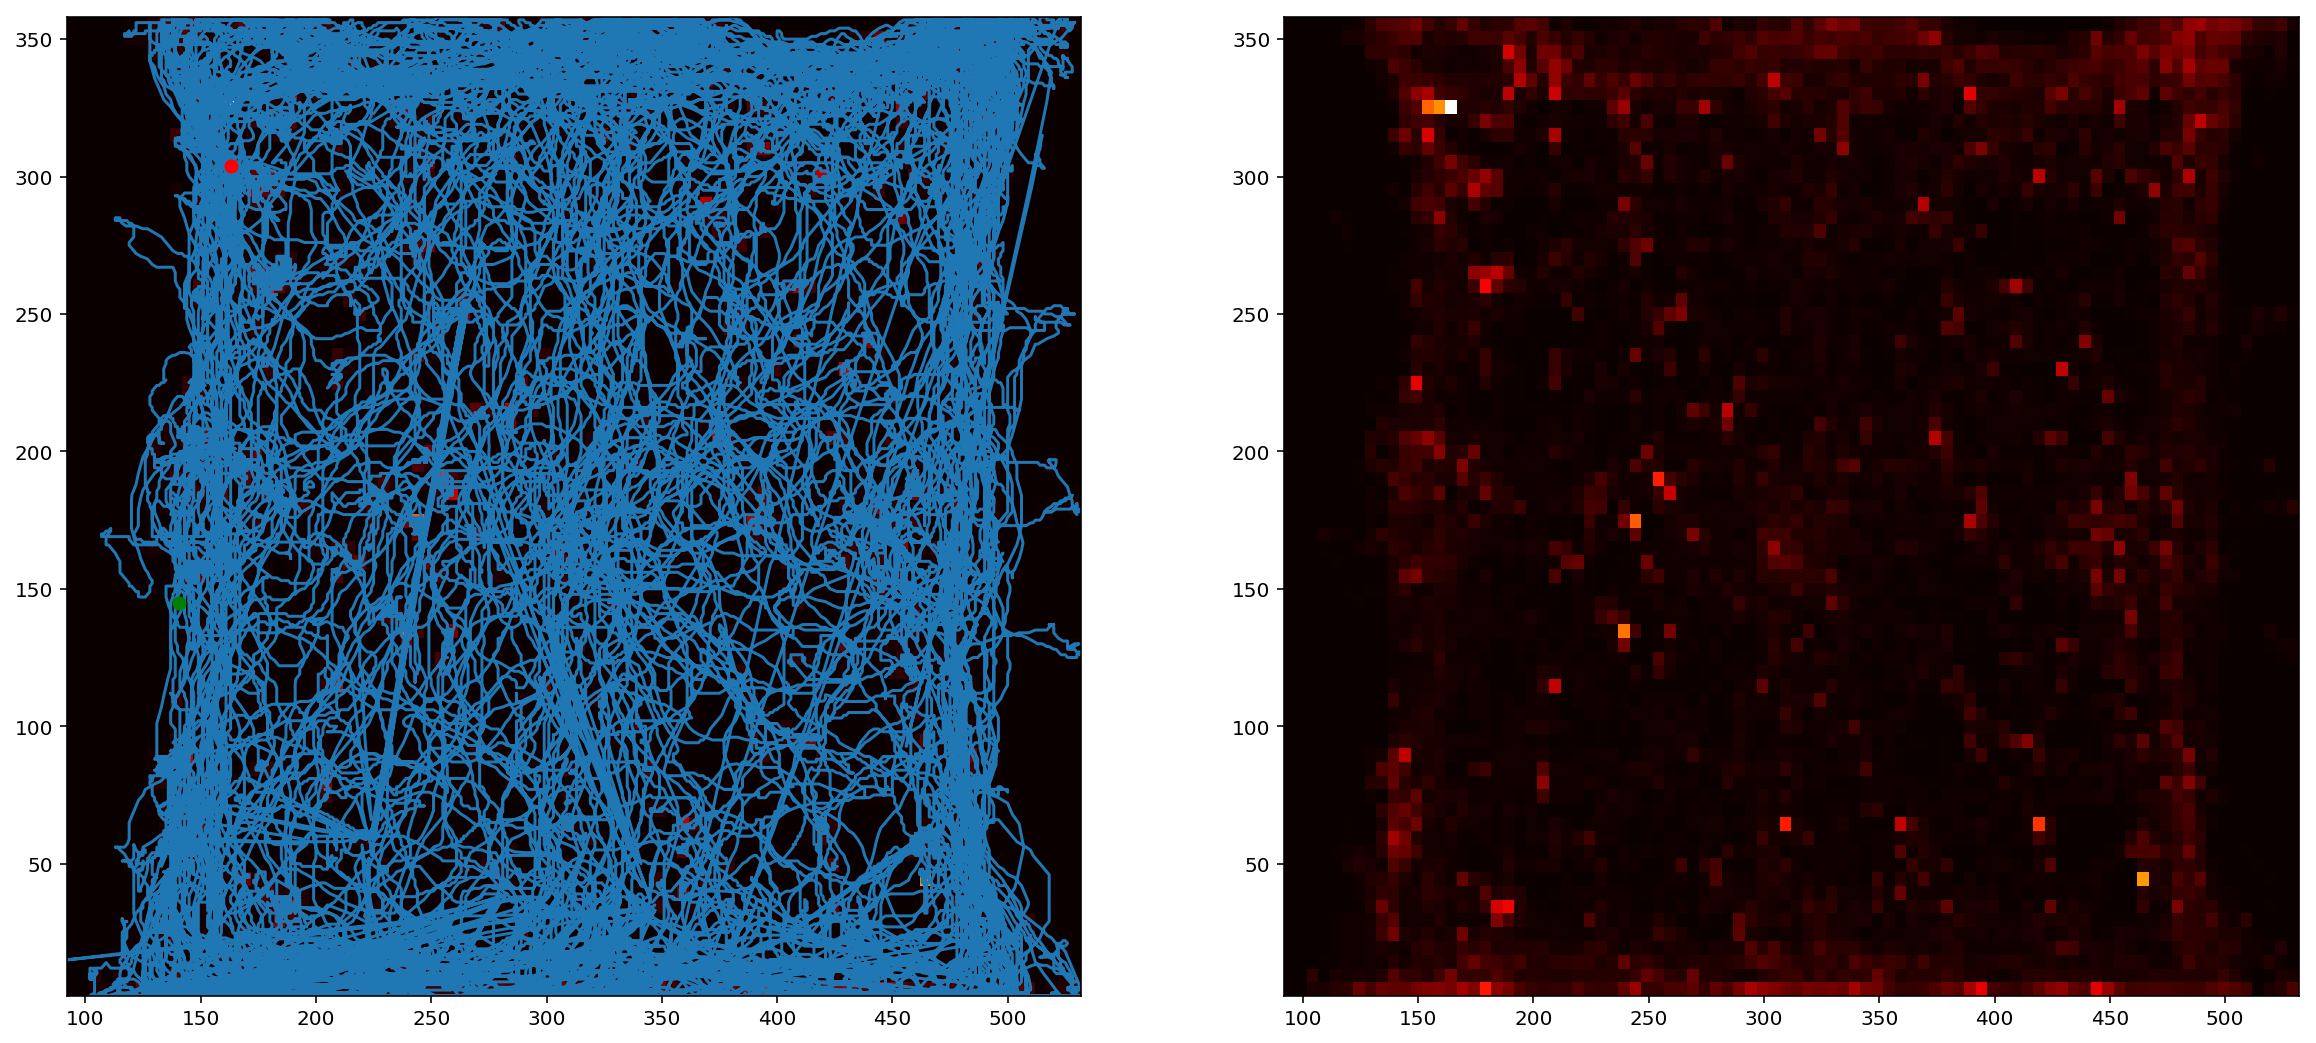

In [17]:
pc.plot_occupation_map()

### maze are 1.4m * 1.4m

In [18]:
pc.ts/60.

array([2.43500000e-02, 2.46277778e-02, 2.49055556e-02, ...,
       4.10326833e+01, 4.10329611e+01, 4.10332389e+01])

In [19]:
pc.v_still_idx

array([     0,    747,    748, ..., 145299, 145300, 145301])

In [20]:
pc.ts[pc.v_still_idx]

array([1.46100000e+00, 1.39110000e+01, 1.39276667e+01, ...,
       2.42311100e+03, 2.42312767e+03, 2.42314433e+03])

In [21]:
spk_time_full = np.load('./dusty_spk_time_full.npy').item()

In [ ]:
pc.get_fields(spk_time_full, kernlen=14, std=3)
pc.rank_fields('spatial_bit_smoothed_spike')

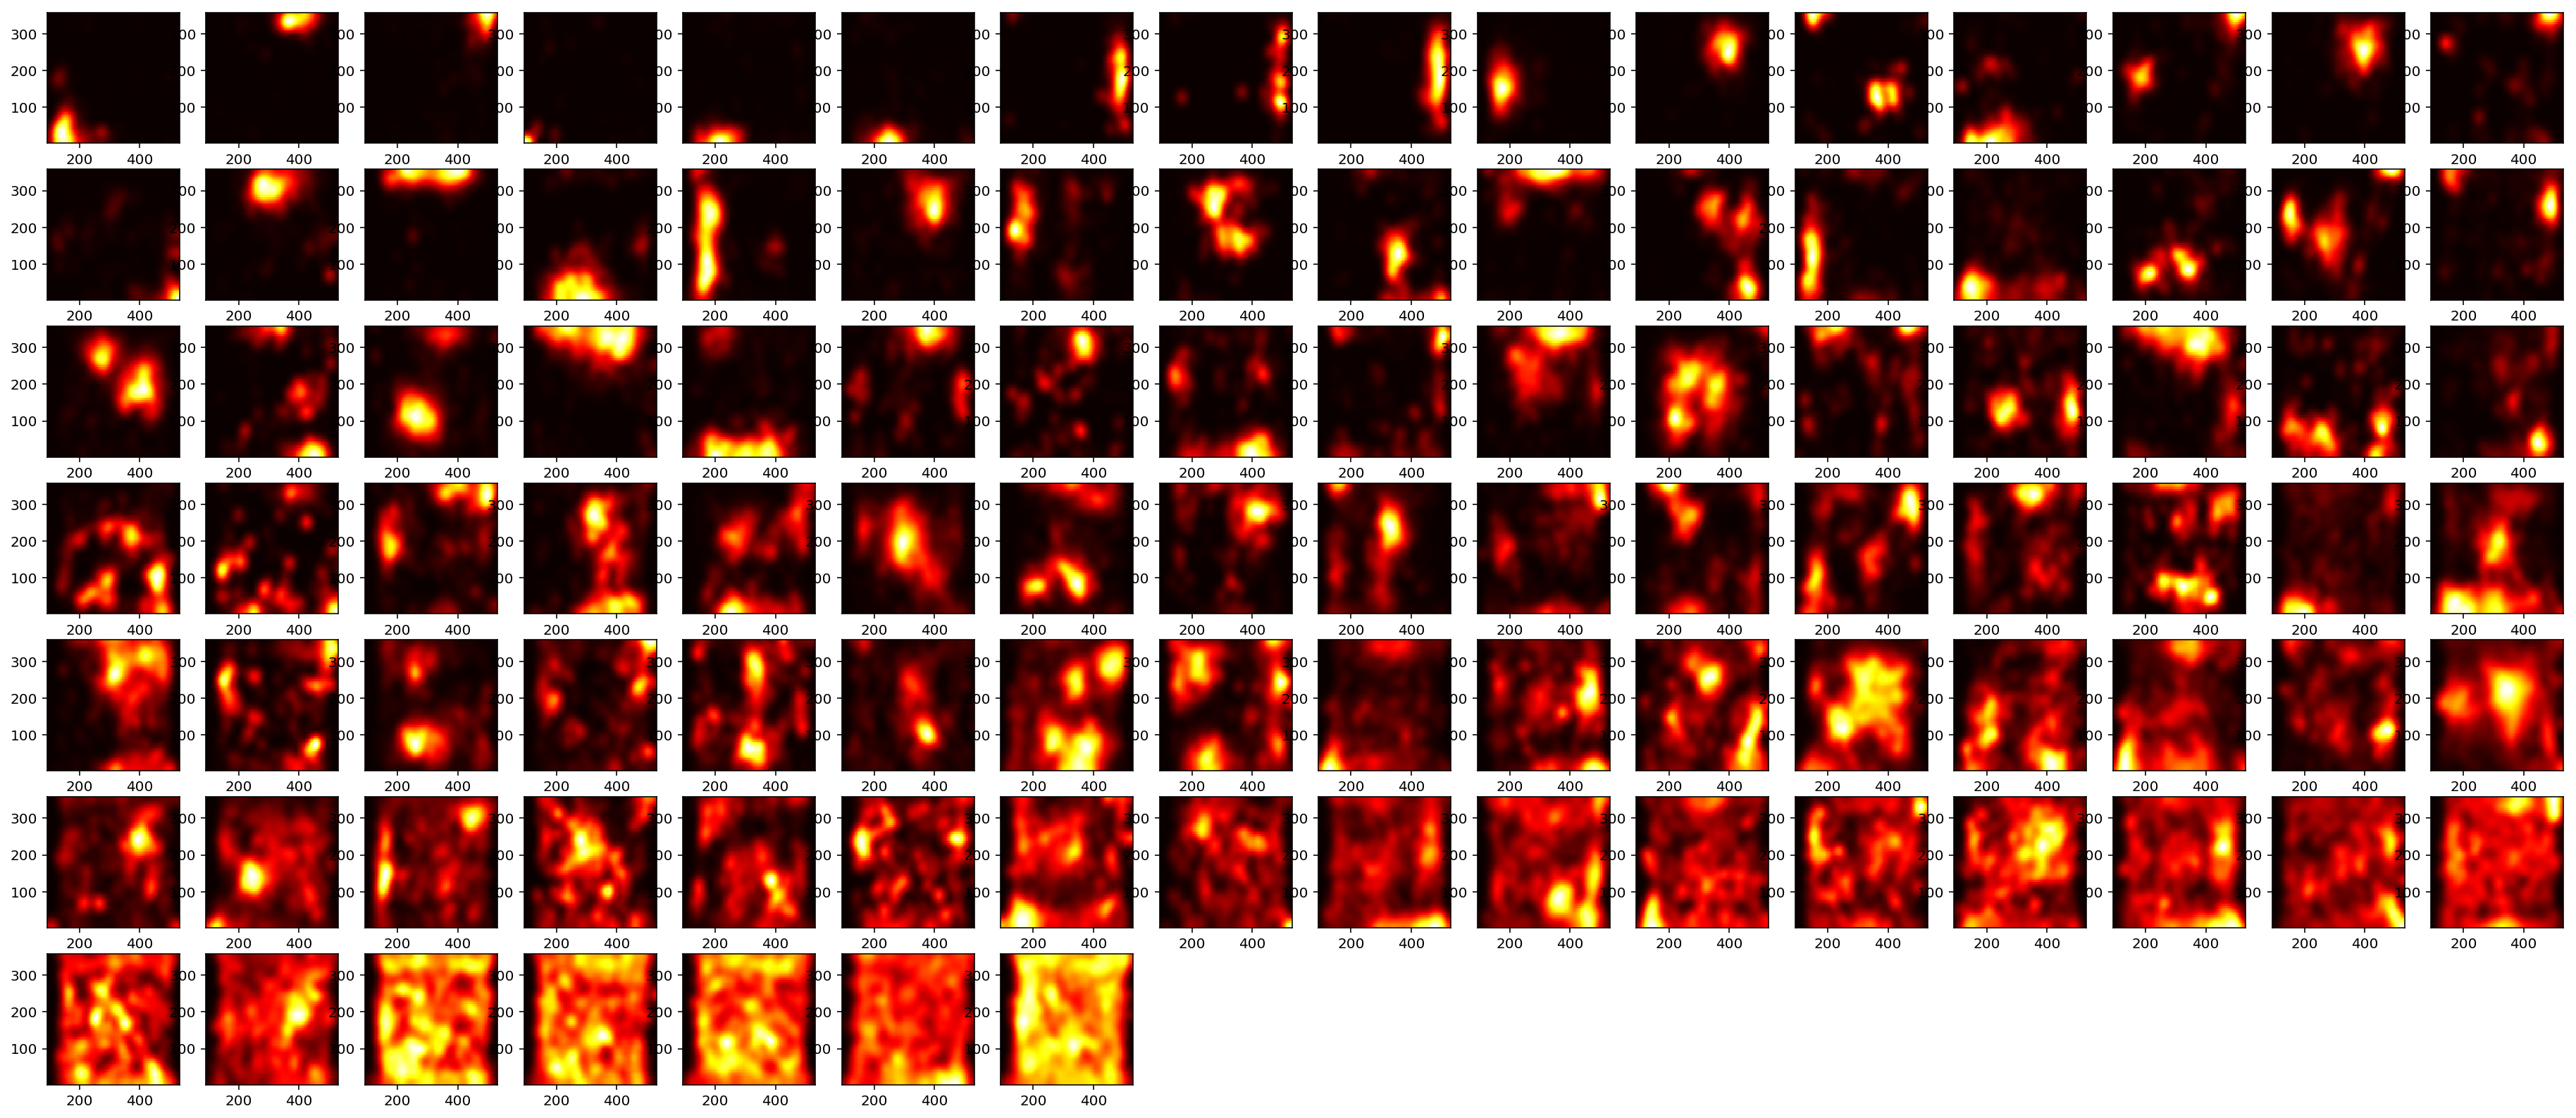

In [28]:
pc.plot_fields(N=16, size=2, cmap='hot', 
                          marker=False, markersize=1, alpha=0.9, order=True);

In [22]:
6*16

96

In [23]:
pwd

u'/Users/laic/Study/place_fields/spiketag_pc/dusty'

## Get single-unit-vector (suv)

In [24]:
from spiketag.analysis import *

In [25]:
delta_t = 250e-3

In [26]:
n_cells = 98

In [29]:
suv = spk_time_to_suv(spk_time_full, pc.ts, delta_t=delta_t, 
                      sublist=pc.sorted_fields_id[:n_cells])

In [30]:
Fr = pc.fields_matrix[pc.sorted_fields_id[:n_cells]]

In [31]:
suv.shape

(98, 147633)

In [32]:
Fr.shape

(98, 71, 88)

## Decoding

In [33]:
Fr[Fr==0] = 1e-25

In [77]:
true_xy, post_2d = bayesian_decoding(Fr=Fr, suv=suv, pos=pc.pos, pos_offset=pc.maze_original, 
                                     bin_size=pc.bin_size, delta_t=delta_t)

In [78]:
500*50

25000

In [79]:
post_2d.shape

(147633, 71, 88)

In [75]:
post_xy = argmax_2d_tensor(X=post_2d)

In [80]:
post_xy.shape

(147633, 2)

In [81]:
def smooth(y, window_len):
    box = np.exp(0.0005*np.arange(window_len))
    box = box/float(box.sum())
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [109]:
smoothed_post_xy = np.zeros_like(post_xy)
smoothed_post_xy[:,0] = smooth(post_xy[:,0], window_len=80)
smoothed_post_xy[:,1] = smooth(post_xy[:,1], window_len=80)

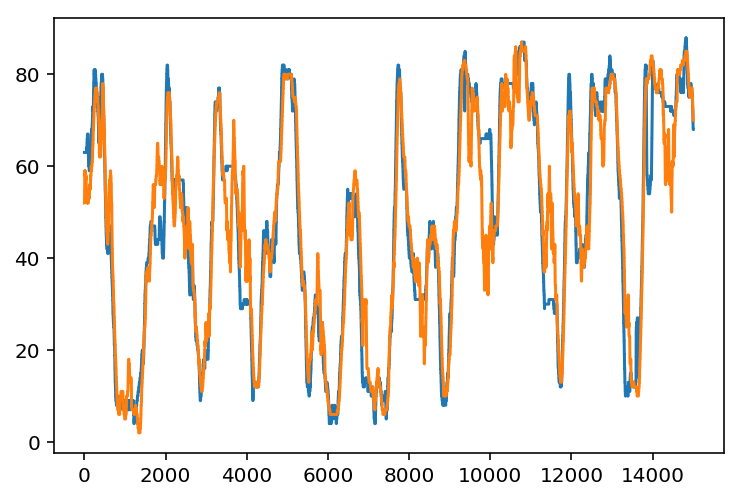

In [110]:
plot(true_xy[10000:25000,0])
plot(smoothed_post_xy[10000:25000,0])

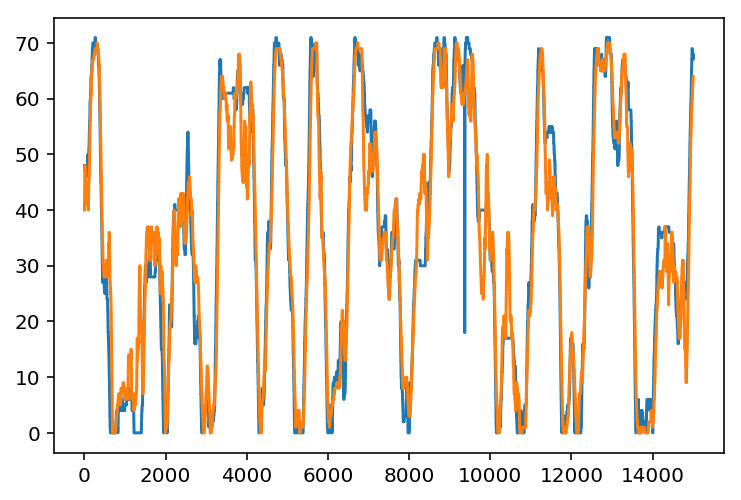

In [111]:
plot(true_xy[10000:25000,1])
plot(smoothed_post_xy[10000:25000,1])

In [112]:
df = np.linalg.norm(true_xy - smoothed_post_xy, axis=1)
df *= pc.bin_size

In [114]:
xy_length = np.linalg.norm(pc.maze_range[:,1] - pc.maze_range[:,0])

In [115]:
print np.median(df[8000:])/xy_length
print np.mean(df[8000:])/xy_length

0.053736328748076115
0.07438085446474342


In [108]:
print np.median(df[8000:])/xy_length
print np.mean(df[8000:])/xy_length

0.055872374136944604
0.07881471426615817


In [58]:
import ipywidgets as widgets

In [97]:
@widgets.interact(i=(0, 25000, 2))
def show_post_2d(i=0):
#     if pc.v_smoothed[i] > 15 and suv[:,i].sum()>5:
    fig, ax = subplots(1,3,figsize=(18,5))
    ax[0].pcolormesh(post_2d[i,:,:])
    ax[0].plot(true_xy[i,0], true_xy[i,1], 'ro', markersize=20, alpha=0.5)
    ax[0].plot(smoothed_post_xy[i,0], smoothed_post_xy[i,1], 'go', markersize=20, alpha=0.5)
    print pc.v_smoothed[i]
    print suv[:,i]
    print suv[:,i]-suv[:,i-1]
    predominate_place_idx = np.argsort(suv[:,i])[::-1][:2]
    print predominate_place_idx
    print suv[predominate_place_idx,i]
    ax[1].pcolormesh(Fr[predominate_place_idx[0], :, :], label=suv[predominate_place_idx[0],i])
    ax[2].pcolormesh(Fr[predominate_place_idx[1], :, :], label=suv[predominate_place_idx[1],i])
    ax[1].legend()
    ax[2].legend()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2knLCBtYXg9MjUwMDAsIHN0ZXA9MiksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGfigKY=


In [ ]:
post_2d = np.delete(post_2d, np.where(pc.v_smoothed<15)[0], axis=0)
true_xy = np.delete(true_xy, np.where(pc.v_smoothed<15)[0], axis=0)

In [ ]:
post_2d.shape

In [ ]:
true

In [ ]:
post_xy = argmax_2d_tensor(X=post_2d)

In [ ]:

post_xy = np.delete(post_xy, np.where(pc.v_smoothed<15)[0], axis=0)

In [ ]:
def smooth(y, window_len):
    box = np.exp(0.0005*np.arange(window_len))
    box = box/float(box.sum())
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
smoothed_post_xy = np.zeros_like(post_xy)
smoothed_post_xy[:,0] = smooth(post_xy[:,0], window_len=80)
smoothed_post_xy[:,1] = smooth(post_xy[:,1], window_len=80)

In [ ]:
plot(true_xy[:20000,0])
plot(smoothed_post_xy[:20000,0])

In [ ]:
plot(true_xy[:20000,1])
plot(smoothed_post_xy[:20000,1])

In [ ]:
@widgets.interact(i=(0,suv.shape[1],2))
def show_post_2d(i=0):
    if pc.v_smoothed[i] > 15 and suv[:,i].sum()>5:
        fig, ax = subplots(1,3,figsize=(18,5))
        ax[0].pcolormesh(post_2d[i,:,:])
        ax[0].plot(true_xy[i,0], true_xy[i,1], 'ro', markersize=20, alpha=0.5)
        ax[0].plot(smooth(ref_post_xy[:,0], 50)[i], smooth(ref_post_xy[:,1], 50)[i], 'go', markersize=20, alpha=0.5)
        print pc.v_smoothed[i]
        print suv[:,i]
        print suv[:,i]-suv[:,i-1]
        predominate_place_idx = np.argsort(suv[:,i])[::-1][:2]
        print predominate_place_idx
        print suv[predominate_place_idx,i]
        ax[1].pcolormesh(Fr[predominate_place_idx[0], :, :], label=suv[predominate_place_idx[0],i])
        ax[2].pcolormesh(Fr[predominate_place_idx[1], :, :], label=suv[predominate_place_idx[1],i])
        ax[1].legend()
        ax[2].legend()